In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import accuracy_score
import lightgbm as lgbm
from sklearn.model_selection import  GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier




In [8]:
train_data = pd.read_csv("data/titanic/train.csv")
test_data = pd.read_csv("data/titanic/test.csv")

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


/home/xiaowa/.virtualenvs/py3.6-env/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


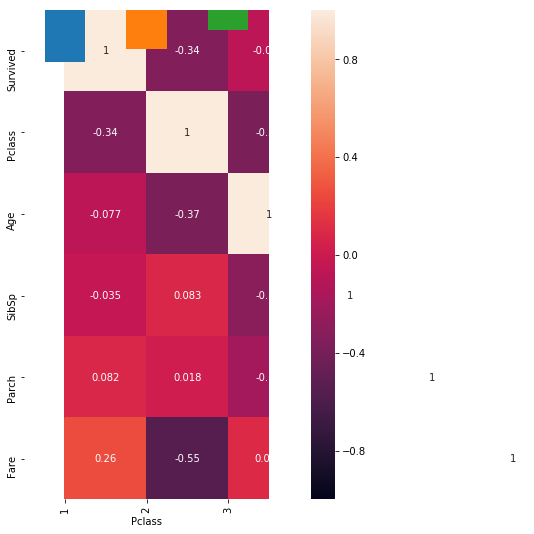

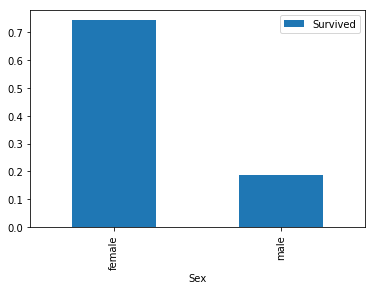

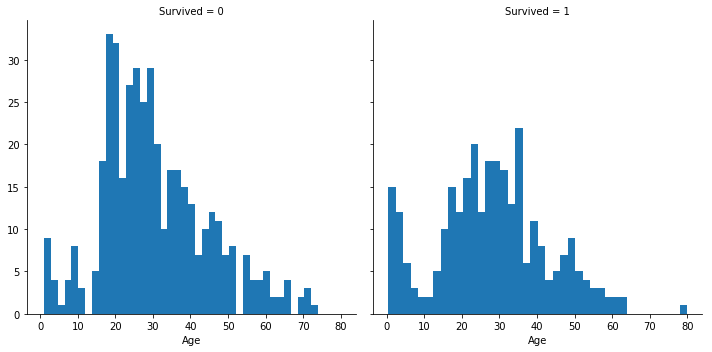

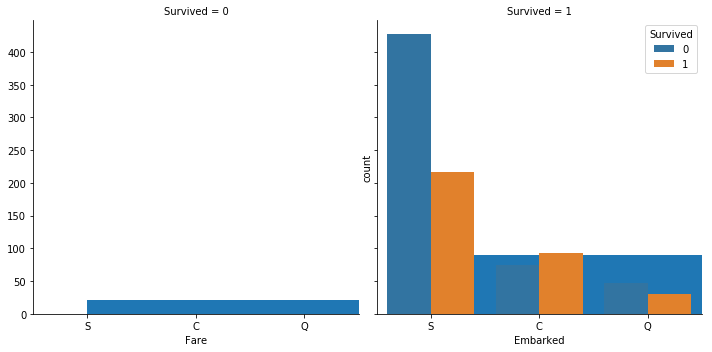

In [9]:
train_data.describe()
train_data.head()
train_data.info()
test_data.info()

train_corr = train_data.drop('PassengerId', axis=1).corr()
train_corr
a = plt.subplots(figsize = (15,9))
sns.heatmap(train_corr,vmin=-1, vmax=1,annot=True, square=True)


train_data.groupby("Pclass")['Survived'].mean().plot.bar()

train_data.groupby(['Sex'])['Sex','Survived'].mean().plot.bar()

g = sns.FacetGrid(train_data, col='Survived',size=5)
g.map(plt.hist, 'Age', bins=40)

g = sns.FacetGrid(train_data, col='Survived',size=5)
g.map(plt.hist, 'Fare', bins=40)
sns.countplot("Embarked", hue = 'Survived', data=train_data)

In [10]:
def feature_parse(df):
    df['SibSp_Parch'] = df['SibSp'] + df['Parch']
    df.Embarked.fillna(df.Embarked.mode()[0], inplace=True)

    df["Fare"].fillna(14.435422,inplace=True)

    df['Name1'] = df['Name'].str.extract('.+,(.+)', expand=False).str.extract('^(.+?)\.', expand=False).str.strip()

    df['Name1'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer' , inplace = True)
    df['Name1'].replace(['Jonkheer', 'Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty' , inplace = True)
    df['Name1'].replace(['Mme', 'Ms', 'Mrs'], 'Mrs', inplace = True)
    df['Name1'].replace(['Mlle', 'Miss'], 'Miss', inplace = True)
    df['Name1'].replace(['Mr'], 'Mr' , inplace = True)
    df['Name1'].replace(['Master'], 'Master' , inplace = True)
    df = pd.get_dummies(df,columns=['Pclass','Sex','SibSp','Parch','SibSp_Parch', "Embarked", 'Name1'])

    df['Name2'] = df['Name'].apply(lambda x: x.split('.')[1])
    Name2_sum = df['Name2'].value_counts().reset_index()
    Name2_sum.columns=['Name2','Name2_sum']
    df = pd.merge(df,Name2_sum,how='left',on='Name2')

    #由于出现一次时该特征时无效特征,用one来代替出现一次的姓
    df.loc[df['Name2_sum'] == 1 , 'Name2_new'] = 'one'
    df.loc[df['Name2_sum'] > 1 , 'Name2_new'] = df['Name2']
    del df['Name2']
    df = pd.get_dummies(df,columns=['Name2_new'])
    del df['Name']



    df['Ticket_Letter'] = df['Ticket'].str.split().str[0]
    df['Ticket_Letter'] = df['Ticket_Letter'].apply(lambda x:np.nan if x.isnumeric() else x)
    df.drop('Ticket',inplace=True,axis=1)
    df = pd.get_dummies(df,columns=['Ticket_Letter'],drop_first=True)




    df.loc[df["Age"].isnull() ,"age_nan"] = 1
    df.loc[df["Age"].notnull() ,"age_nan"] = 0
    df = pd.get_dummies(df,columns=['age_nan'])

    missing_age = df.drop(['Survived','Cabin'],axis=1)

    #分列处理


    #将Age完整的项作为训练集、将Age缺失的项作为测试集。
    missing_age_train = missing_age[missing_age['Age'].notnull()]
    missing_age_test = missing_age[missing_age['Age'].isnull()]
    missing_age_X_train = missing_age_train.drop(['Age'], axis=1)
    missing_age_Y_train = missing_age_train['Age']
    missing_age_X_test = missing_age_test.drop(['Age'], axis=1)

    # 先将数据标准化
    from sklearn.preprocessing import StandardScaler
    ss = StandardScaler()
    #用测试集训练并标准化


    ss.fit(missing_age_X_train)
    missing_age_X_train = ss.transform(missing_age_X_train)
    missing_age_X_test = ss.transform(missing_age_X_test)
    lin = linear_model.BayesianRidge()
    lin.fit(missing_age_X_train,missing_age_Y_train)
    df.loc[(df['Age'].isnull()), 'Age'] = lin.predict(missing_age_X_test)

    df['Age'] = pd.cut(df['Age'], bins=[0,10,18,30,50,100],labels=[1,2,3,4,5])
    df = pd.get_dummies(df,columns=['Age'])


    df['Cabin_nan'] = df['Cabin'].apply(lambda x:str(x)[0] if pd.notnull(x) else x)
    df = pd.get_dummies(df,columns=['Cabin_nan'])
    df.loc[df["Cabin"].isnull() ,"Cabin_nan"] = 1
    df.loc[df["Cabin"].notnull() ,"Cabin_nan"] = 0
    df = pd.get_dummies(df,columns=['Cabin_nan'])
    df.drop(['Cabin', 'PassengerId'],axis=1,inplace=True)
    
    return df


In [11]:
def split_data(df, train_num):
    train_data = df[:train_num]
    test_data = df[train_num:]
    train_data_X = train_data.drop(['Survived'],axis=1)
    train_data_Y = train_data['Survived']
    test_data_X = test_data.drop(['Survived'],axis=1)
    return train_data_X, train_data_Y, test_data_X

test_data['Survived'] = 0
train_test = train_data.append(test_data)
train_test.info()
parsed_data = feature_parse(train_test)


train_data_X, train_data_Y, test_data_X = split_data(parsed_data, train_data.shape[0])
train_data_X.head()
train_data_X.info()

ss2 = StandardScaler()
ss2.fit(train_data_X)
train_data_X_sd = ss2.transform(train_data_X)
test_data_X_sd = ss2.transform(test_data_X)
train_data_X_sd


/home/xiaowa/.virtualenvs/py3.6-env/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/home/xiaowa/.virtualenvs/py3.6-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/xiaowa/.virtualenvs/py3.6-env/lib/python3.6/site-packages/ipykernel_launcher.py:62: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/home/xiaowa/.virtualenvs/py3.6-env/lib/python3.6/site-packages/ipykernel_launcher.py:63: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to floa

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       1309 non-null int64
Ticket         1309 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 132.9+ KB


,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,SibSp_3,...,Cabin_nan_A,Cabin_nan_B,Cabin_nan_C,Cabin_nan_D,Cabin_nan_E,Cabin_nan_F,Cabin_nan_G,Cabin_nan_T,Cabin_nan_0.0,Cabin_nan_1.0
0,7.2500,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,71.2833,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
2,7.9250,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,53.1000,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,8.0500,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Columns: 195 entries, Fare to Cabin_nan_1.0
dtypes: float64(1), int64(1), uint8(193)
memory usage: 188.8 KB


/home/xiaowa/.virtualenvs/py3.6-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

/home/xiaowa/.virtualenvs/py3.6-env/lib/python3.6/site-packages/ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/home/xiaowa/.virtualenvs/py3.6-env/lib/python3.6/site-packages/ipykernel_launcher.py:22: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


array([[-0.50244517, -0.56568542, -0.51015154, ..., -0.03352008,
        -0.54492498,  0.54492498],
       [ 0.78684529,  1.76776695, -0.51015154, ..., -0.03352008,
         1.835115  , -1.835115  ],
       [-0.48885426, -0.56568542, -0.51015154, ..., -0.03352008,
        -0.54492498,  0.54492498],
       ...,
       [-0.17626324, -0.56568542, -0.51015154, ..., -0.03352008,
        -0.54492498,  0.54492498],
       [-0.04438104,  1.76776695, -0.51015154, ..., -0.03352008,
         1.835115  , -1.835115  ],
       [-0.49237783, -0.56568542, -0.51015154, ..., -0.03352008,
        -0.54492498,  0.54492498]])

In [12]:
train_data_X.head()
train_data_X.info()

,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,SibSp_3,...,Cabin_nan_A,Cabin_nan_B,Cabin_nan_C,Cabin_nan_D,Cabin_nan_E,Cabin_nan_F,Cabin_nan_G,Cabin_nan_T,Cabin_nan_0.0,Cabin_nan_1.0
0,7.2500,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,71.2833,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
2,7.9250,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,53.1000,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
4,8.0500,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Columns: 195 entries, Fare to Cabin_nan_1.0
dtypes: float64(1), int64(1), uint8(193)
memory usage: 188.8 KB


In [14]:
def eval_result(model, x, y):
    pred = model.predict(x)
    acc = accuracy_score(pred, y)
    auc = roc_auc_score(pred, y)
    
    return dict(acc=acc,auc=auc)



In [45]:
def grid_train(clazz, best_params, grid_params, n_fold=5, scoring= 'roc_auc'):
    model = clazz(**best_params)
    clf = GridSearchCV(model, grid_params, cv=n_fold, n_jobs=4, verbose=1, scoring=scoring)
    clf.fit(train_data_X_sd, train_data_Y)
    detail = clf.cv_results_
    best_params.update(clf.best_params_)
    best_model = clazz(**best_params)
    return detail, best_params, best_model
    


In [33]:
def predict(model, x, adjust=0.37320):    
    arr = model.predict(x)
    print("origin rate:", sum(arr)/arr.shape[0])
    if adjust:
        tmp = model.predict_proba(x)[:,-1]
        rank = int(tmp.shape[0] * adjust)
        threshold = np.sort(tmp)[::-1][rank]
        arr = np.array([1 if e>=threshold else 0 for e in tmp])
    rs_df = pd.DataFrame(arr, columns=['Survived'], dtype=np.int)   
    return rs_df

from utils import  get_today_str
import sys, os
COMP_NAME = 'titanic'

def get_result(df, label_arr, label, record=False, submit=False, message=''):
    id_series = df['PassengerId'].astype(np.int)
    label_series = label_arr
    rs_df = pd.concat([id_series, label_series], axis=1)
    if record:
        path = 'submit/titanic/{label}-{day}.csv'.format(day=get_today_str(), label=label)
        rs_df.to_csv(path,index=False)
        if submit:
            do_submit(COMP_NAME, path, message)
    return rs_df

def do_execute(cmd):
    print("executing cmd:{}".format(cmd))
    return os.system(cmd)

def do_submit(comp_name, path, message):
    cmd = 'kaggle competitions submit -c {comp_name} -f {path} -m "{message}"'.format(comp_name=comp_name, path=path, message=message)
    return do_execute(cmd)





    
    
    
    



In [56]:
best_clf_dict = {}

In [57]:
best_params = {'n_estimators': 115,
 'max_depth': 15,
 'learning_rate': 0.05,
 'subsample': 0.01,
 'reg_alpha': 0.05,
 'reg_lambda': 0.05,
 'num_leaves': 48,
 'colsample_bytree': 0.5}


grid_params = dict(
                   subsample= [0.01,0.02,0.05,0.1,0.15],
                   reg_lambda= [0.0, 0.01,0.05, 0.1,0.2],
                   colsample_bytree = [0.1, 0.2,0.5,1.]
)
clazz = lgbm.LGBMClassifier
detail, nest_param, best_lgbm = grid_train(clazz, best_params, grid_params)
best_lgbm.fit(train_data_X_sd, train_data_Y)

best_lgbm
test_score = max(detail["mean_test_score"])
best_clf_dict["best_lgbm"] = (best_lgbm, test_score)
best_clf_dict


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    5.7s finished


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
        importance_type='split', learning_rate=0.05, max_depth=15,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=115, n_jobs=-1, num_leaves=48, objective=None,
        random_state=None, reg_alpha=0.05, reg_lambda=0.05, silent=True,
        subsample=0.01, subsample_for_bin=200000, subsample_freq=0)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
        importance_type='split', learning_rate=0.05, max_depth=15,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=115, n_jobs=-1, num_leaves=48, objective=None,
        random_state=None, reg_alpha=0.05, reg_lambda=0.05, silent=True,
        subsample=0.01, subsample_for_bin=200000, subsample_freq=0)

{'best_lgbm': (LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
          importance_type='split', learning_rate=0.05, max_depth=15,
          min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
          n_estimators=115, n_jobs=-1, num_leaves=48, objective=None,
          random_state=None, reg_alpha=0.05, reg_lambda=0.05, silent=True,
          subsample=0.01, subsample_for_bin=200000, subsample_freq=0),
  0.8797477224399548)}

In [58]:
from sklearn.linear_model import LogisticRegression

best_params = dict(max_iter=80, C= 0.01)

grid_params = dict(C=[0.01, 0.001, 0.02, 0.005])

clazz = LogisticRegression

detail, nest_param, best_lr = grid_train(clazz, best_params, grid_params)
best_lr.fit(train_data_X_sd, train_data_Y)

best_lr
test_score  = max(detail["mean_test_score"])
best_clf_dict["best_lr"] = (best_lr, test_score)
best_clf_dict



Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.4s finished
/home/xiaowa/.virtualenvs/py3.6-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/xiaowa/.virtualenvs/py3.6-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=80, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=80, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

{'best_lgbm': (LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
          importance_type='split', learning_rate=0.05, max_depth=15,
          min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
          n_estimators=115, n_jobs=-1, num_leaves=48, objective=None,
          random_state=None, reg_alpha=0.05, reg_lambda=0.05, silent=True,
          subsample=0.01, subsample_for_bin=200000, subsample_freq=0),
  0.8797477224399548),
 'best_lr': (LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=80, multi_class='warn',
            n_jobs=None, penalty='l2', random_state=None, solver='warn',
            tol=0.0001, verbose=0, warm_start=False), 0.8693451853877824)}

In [59]:

best_params = dict(n_estimators=80,min_samples_leaf=2,max_depth=7,oob_score=True)
grid_params = dict(min_samples_leaf=[1,2,3,4,5])


clazz = RandomForestClassifier

detail, nest_param, best_rf = grid_train(clazz, best_params, grid_params)
best_rf.fit(train_data_X_sd, train_data_Y)

test_score  = max(detail["mean_test_score"])
best_clf_dict["best_rf"] = (best_rf, test_score)
best_clf_dict

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.6s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

{'best_lgbm': (LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
          importance_type='split', learning_rate=0.05, max_depth=15,
          min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
          n_estimators=115, n_jobs=-1, num_leaves=48, objective=None,
          random_state=None, reg_alpha=0.05, reg_lambda=0.05, silent=True,
          subsample=0.01, subsample_for_bin=200000, subsample_freq=0),
  0.8797477224399548),
 'best_lr': (LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=80, multi_class='warn',
            n_jobs=None, penalty='l2', random_state=None, solver='warn',
            tol=0.0001, verbose=0, warm_start=False), 0.8693451853877824),
 'best_rf': (RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=7, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=

In [62]:
from sklearn.svm import SVC

best_params = dict(C=0.5,max_iter=350, probability=True)
grid_params = dict(C=[0.5,1,1.5])

clazz = SVC

detail, nest_param, best_svc = grid_train(clazz, best_params, grid_params)
best_svc.fit(train_data_X_sd, train_data_Y)

test_score  = max(detail["mean_test_score"])
best_clf_dict["best_svc"] = (best_svc, test_score)
best_clf_dict


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    1.7s finished
/home/xiaowa/.virtualenvs/py3.6-env/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/xiaowa/.virtualenvs/py3.6-env/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=350).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/xiaowa/.virtualenvs/py3.6-env/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to

SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=350, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

{'best_lgbm': (LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
          importance_type='split', learning_rate=0.05, max_depth=15,
          min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
          n_estimators=115, n_jobs=-1, num_leaves=48, objective=None,
          random_state=None, reg_alpha=0.05, reg_lambda=0.05, silent=True,
          subsample=0.01, subsample_for_bin=200000, subsample_freq=0),
  0.8797477224399548),
 'best_lr': (LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=80, multi_class='warn',
            n_jobs=None, penalty='l2', random_state=None, solver='warn',
            tol=0.0001, verbose=0, warm_start=False), 0.8693451853877824),
 'best_rf': (RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=7, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=

In [94]:
from sklearn.model_selection import StratifiedKFold
class StackingModel:
    def __init__(self, clf_list, clf2, n_folds):
        self.clf_list  = clf_list
        self.clf_instance_list = []
        
        self.clf2 = clf2
        self.n_folds = n_folds

        
        
    def fit(self, X, y):
        skf = StratifiedKFold(n_splits=self.n_folds)
        skf.get_n_splits(X, y)
        self.clf_instance_list = []
        self.second_x = np.zeros((X.shape[0], len(clf_list)))
        for i, m in enumerate(self.clf_list):   
            instance_list = []
            for j, (train_idx, test_idx) in enumerate(skf.split(X,y)):
                tmp_x = X[train_idx]
                tmp_y = y[train_idx]
                tmp_m = copy.copy(m)
                tmp_m = tmp_m.fit(tmp_x, tmp_y)
                tmp_pred_x = X[test_idx]
                
                self.second_x[test_idx, i] = tmp_m.predict_proba(tmp_pred_x)[:,-1]
                instance_list.append(tmp_m)
                
            self.clf_instance_list.append(instance_list)

        self.clf2.fit(self.second_x, y)
        return self
    
    def parse_predict_x(self, X):
        second_x = np.zeros((X.shape[0], len(self.clf_list)))
        for idx, instance_list in enumerate(self.clf_instance_list):
            tmp_x = np.zeros((X.shape[0], len(instance_list)))
            for j, instance in enumerate(instance_list):
                tmp_x[:,j] = instance.predict_proba(X)[:,-1]
            tmp = np.mean(tmp_x, axis=1)
            second_x[:,idx] = tmp
        return second_x
    
    def predict_proba(self, X):
        second_x = self.parse_predict_x(X)
        return self.clf2.predict_proba(second_x)
    
    def predict(self, X):
        second_x = self.parse_predict_x(X)
        return self.clf2.predict(second_x)
        
                  
            
clf_list = [e[0] for e in best_clf_dict.values()]
clf2 = LogisticRegression(C=0.1,max_iter=100)
stacking_model = StackingModel(clf_list,clf2, 5)
stacking_model.fit(train_data_X_sd, train_data_Y)
# stacking_model.clf_instance_list

# stacking_model.second_x
# 

# stacking_model.parse_predict_x(train_data_X_sd)

# stacking_model.predict(train_data_X_sd)
# stacking_model.predict_proba(train_data_X_sd)


# eval_result(stacking_model, train_data_X_sd, train_data_Y)


# stacking_model.predict_proba(test_data_X_sd)
        



        

        
        
        
        
        
        
        
        
        
        



/home/xiaowa/.virtualenvs/py3.6-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/xiaowa/.virtualenvs/py3.6-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/xiaowa/.virtualenvs/py3.6-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/xiaowa/.virtualenvs/py3.6-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/xiaowa/.virtualenvs/py3.6-env/lib/python3.6/site-packages/sklearn/linear_model/logisti

array([[0.06272351, 0.17422427, 0.14161532, 0.15383874],
       [0.96068218, 0.91624658, 0.91925622, 0.88109965],
       [0.50411192, 0.60330097, 0.53913274, 0.55844144],
       ...,
       [0.20892599, 0.4384676 , 0.41655687, 0.34489578],
       [0.63402394, 0.49312461, 0.39994219, 0.25006994],
       [0.01583228, 0.11311615, 0.1009569 , 0.15537008]])

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,

array([[0.82863318, 0.17136682],
       [0.14702929, 0.85297071],
       [0.45930168, 0.54069832],
       ...,
       [0.67445193, 0.32554807],
       [0.51456902, 0.48543098],
       [0.85070192, 0.14929808]])

In [99]:
def all_in_one(model, label, record, submit):
    print(eval_result(model, train_data_X_sd, train_data_Y))
    pred = predict(model, test_data_X_sd)
    rs = get_result(test_data, pred, label, record, submit)
    return rs
    
rs = all_in_one(stacking_model, 'stack', True, False)
rs.describe()


# eval_result(stacking_model, train_data_X_sd, train_data_Y)

{'acc': 0.8731762065095399, 'auc': 0.8704948394684487}
origin rate: 0.36363636363636365


,PassengerId,Survived
count,418.000000,418.000000
mean,1100.500000,0.373206
std,120.810458,0.484236
min,892.000000,0.000000
25%,996.250000,0.000000
50%,1100.500000,0.000000
75%,1204.750000,1.000000
max,1309.000000,1.000000


In [211]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Activation
from keras import regularizers

train_data_X_sd.shape
train_data_Y.reshape((-1,1)).shape


k_model = Sequential()
k_model.add(Dense(units=256, input_dim = train_data_X_sd.shape[1], activation="relu"))
k_model.add(Dense(units=128,activation="relu"))
k_model.add(Dense(units=64,activation="relu"))
k_model.add(Dense(units=64,activation="relu"))
k_model.add(Dense(units=1,activation="sigmoid",activity_regularizer=regularizers.l2(0.02)))



k_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
k_model.fit(train_data_X_sd, train_data_Y, validation_split=0.1, epochs=50, batch_size=32,
            callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=0,
                              verbose=1, mode='auto')])








# k_model = 

(891, 195)

/Users/jerry/py-envs/lml-py/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


(891, 1)

ValueError: Unknown metric function:roc-auc

In [213]:
tmp = predict(k_model, test_data_X_sd)
get_result(test_data, tmp, 'keras', True)

# k_model.predict_proba(train_data_X_sd)

[0.47081625]


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1
5,897,1
6,898,0
7,899,1
8,900,1
9,901,1
